In [1]:
# Program To Read video 
# and Extract Frames 

# import sys
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install moviepy

import cv2 
import os
import sys
import shutil
import numpy as np
import moviepy.video.io.ImageSequenceClip
import torch 
import numpy as np
from PIL import Image
from torch import optim, nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision import transforms

In [2]:
def FrameCapture(path, vid_num): 
      
    # Path to video file 
    vidObj = cv2.VideoCapture(path) 
  
    # Used as counter variable 
    count = 0
    success = 1
    images=[]
    try:
        shutil.rmtree("lebron_dunk" + str(vid_num))
        os.mkdir("lebron_dunk" + str(vid_num))
    except OSError as e:
        os.mkdir("lebron_dunk" + str(vid_num))
    while success: 
  
        # vidObj object calls read 
        # function extract frames 
        success, image = vidObj.read() 
        # Saves the frames with frame-count 
        if image is not None and len(image) > 0:
            cv2.imwrite("lebron_dunk" + str(vid_num) + "/frame" + str(1000+count) + ".jpg", image) 
            img = Image.open("lebron_dunk" + str(vid_num) + "/frame" + str(1000+count) + ".jpg")
            img = img.resize((img.size[0]//10, img.size[1]//10), Image.ANTIALIAS)
            img.save("lebron_dunk" + str(vid_num) + "/frame" + str(1000+count) + ".jpg")
            img = ToTensor()(img) # unsqueeze to add artificial first dimension
            images.append(img)
        count += 1
#     return np.array(images).astype(np.float32)
    return images

In [143]:
data = []
for i in range(1, 11):
    temp = FrameCapture("movies/lebron_dunk" + str(i) + ".mp4", i)
    data.append(temp)

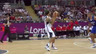

In [4]:
def recreate_movie(image_folder, new_name):
    fps=30
    image_files = [image_folder+'/'+img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    image_files.sort()
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
    clip.write_videofile(new_name + '.mp4')

In [5]:
def display_tensor_image(result):
    im = transforms.ToPILImage()(result).convert("RGB")
    display(im)

In [29]:
recreate_movie('lebron_dunk1', 'recreated_movies/lebron_1')

Moviepy - Building video recreated_movies/lebron_1.mp4.
Moviepy - Writing video recreated_movies/lebron_1.mp4

Moviepy - Done !
Moviepy - video ready recreated_movies/lebron_1.mp4


In [38]:
len(data[0])

119

In [13]:
from torchvision import datasets, transforms

## YOUR CODE HERE ##
latent_dim = 20
transformations = transforms.ToTensor()
# mnist_train =  datasets.MNIST(loc_data, train=True, download=True, transform = transformations)
# mnist_test = datasets.MNIST(loc_data, train=False, download=True, transform = transformations)

In [49]:
images = data[0]
batch_size = 5
x_len = images[0].shape[0]
y_len = images[0].shape[1]
z_len = images[0].shape[2]
total_len = images[0].shape[0]*images[0].shape[1]*images[0].shape[2]

In [50]:
from torch.utils.data import DataLoader
train_loader = DataLoader(images,batch_size=batch_size,drop_last = True,shuffle=True)

In [100]:

class Encoder(nn.Module):
  def __init__(self, x_len=x_len, y_len=y_len, z_len=z_len, latent_dim=latent_dim):
    super(Encoder, self).__init__()
    ## YOUR CODE HERE ##
    total_len = x_len*y_len*z_len
    self.lin1 = nn.Linear(total_len, total_len*3//4)
    self.lin2 = nn.Linear(total_len*3//4, total_len*1//4)
    self.lin3a = nn.Linear(total_len*1//4, latent_dim)
    self.lin3b = nn.Linear(total_len*1//4, latent_dim)
  
  def forward(self, x):
    ## YOUR CODE HERE ##\
    x = x.view(-1, total_len)
#     print(x)
    x = nn.functional.relu(self.lin1(x))
#     print(x)
    x = nn.functional.relu(self.lin2(x))
    # mu, log_var
    return self.lin3a(x), self.lin3b(x)

class Decoder(nn.Module):
  def __init__(self, x_len=x_len, y_len=y_len, z_len=z_len, latent_dim=latent_dim):
    super(Decoder, self).__init__()
    ## YOUR CODE HERE ##
    total_len = x_len*y_len*z_len
    self.lin1 = nn.Linear(latent_dim, total_len*1//4)
    self.lin2 = nn.Linear(total_len*1//4, total_len*3//4)
    self.lin3 = nn.Linear(total_len*3//4, total_len)

  def forward(self,x):
    ## YOUR CODE HERE ##
    x = nn.functional.relu(self.lin1(x))
    x = nn.functional.relu(self.lin2(x))
    x = torch.sigmoid(self.lin3(x))
    return x.view(-1, x_len, y_len, z_len)

In [52]:
from torch import exp, randn_like
def sample(mu, logvar):
  ## YOUR CODE HERE ##
    std_dev = exp(0.5*logvar)
    return randn_like(mu)*std_dev + mu

In [53]:
from scipy.stats import norm
def vae_loss(x, x_hat, mu, logvar):
  ## YOUR CODE HERE ##
  # MSE LOSS + KL DIVERGENCE 
    mse_loss = torch.nn.MSELoss(reduction='sum')
#     mse = torch.mean(torch.pow(x-x_hat, 2))
    kl = -0.5*torch.mean(1 + logvar - torch.pow(mu, 2) - torch.exp(logvar))
    return (mse_loss(x, x_hat) + kl)

In [54]:


## YOUR CODE HERE ##
encoder = Encoder(latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim)
params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(params, lr=1e-3)

In [101]:
def train(encoder, decoder, train_loader, optimizer, num_epochs = 10, x_len=x_len, y_len=y_len,z_len=z_len):
    encoder.train()
    decoder.train()
    total_len = x_len*y_len*z_len
    i=0
    for epoch in range(num_epochs):
        train_loss=0
        for idx, data in enumerate(train_loader):
            data = data.view(-1, x_len, y_len, z_len)
#             print(data.shape)
            optimizer.zero_grad()
            mu, log_var = encoder(data)
            result = decoder(sample(mu, log_var))
#             print(result)
#             if i != 0:
#                 return
            loss = vae_loss(result, data, mu, log_var)
            i+=1
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if idx%10 == 0 :
                print("Epoch: " + str(epoch+1) + " Batch: " + str(idx+1)+"/"+str(len(train_loader.dataset)//batch_size) + " Loss: " + str(loss.item() / len(data)))
        print("Epoch: " + str(epoch+1) + " avg loss: " + str(train_loss / len(train_loader.dataset)))

In [56]:
train(encoder, decoder, train_loader, optimizer, num_epochs = 50)

Epoch: 1 Batch: 1/23 Loss: 1103.0486328125
Epoch: 1 Batch: 11/23 Loss: 1699.45390625
Epoch: 1 Batch: 21/23 Loss: 654.380810546875
Epoch: 1 avg loss: 1325.7957568769696
Epoch: 2 Batch: 1/23 Loss: 465.247509765625
Epoch: 2 Batch: 11/23 Loss: 374.208837890625
Epoch: 2 Batch: 21/23 Loss: 381.5975341796875
Epoch: 2 avg loss: 415.37649356617646
Epoch: 3 Batch: 1/23 Loss: 396.3885498046875
Epoch: 3 Batch: 11/23 Loss: 394.92109375
Epoch: 3 Batch: 21/23 Loss: 459.25390625
Epoch: 3 avg loss: 354.7137605042017
Epoch: 4 Batch: 1/23 Loss: 384.5193115234375
Epoch: 4 Batch: 11/23 Loss: 337.477197265625
Epoch: 4 Batch: 21/23 Loss: 332.2826904296875
Epoch: 4 avg loss: 326.7909633091518
Epoch: 5 Batch: 1/23 Loss: 367.5441162109375
Epoch: 5 Batch: 11/23 Loss: 304.22919921875
Epoch: 5 Batch: 21/23 Loss: 290.5679931640625
Epoch: 5 avg loss: 298.80782747669383
Epoch: 6 Batch: 1/23 Loss: 299.9987060546875
Epoch: 6 Batch: 11/23 Loss: 301.244189453125
Epoch: 6 Batch: 21/23 Loss: 316.9137451171875
Epoch: 6 avg 

In [65]:
torch.save(encoder, "models/lebron1_encoder")
torch.save(decoder, "models/lebron1_decoder")

In [68]:
encoder2 = torch.load("models/lebron1_encoder")
encoder2.eval()
decoder2 = torch.load("models/lebron1_decoder")
decoder2.eval()

Decoder(
  (lin1): Linear(in_features=20, out_features=3888, bias=True)
  (lin2): Linear(in_features=3888, out_features=11664, bias=True)
  (lin3): Linear(in_features=11664, out_features=15552, bias=True)
)

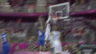

In [70]:
Amu, Alog_var = encoder2(images[118])
Aresult = decoder2(sample(Amu, Alog_var))
display_tensor_image(Aresult[0])

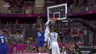

In [63]:
display_tensor_image(images[118])

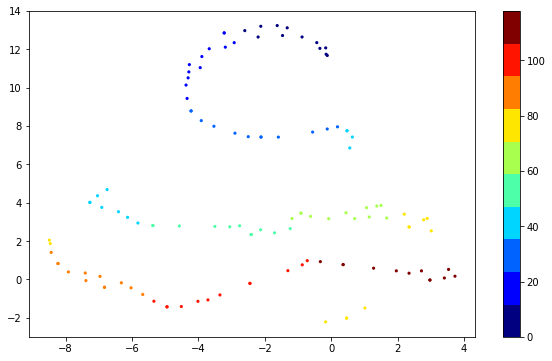

In [146]:
test_features = []
test_labels=[]
for i in range(len(images)):
    z, sigma = encoder2(images[i])
    z = z.detach().numpy()
    z = np.squeeze(z)
    test_features.append(z)
    test_labels.append(i)
    
test_features = np.array(test_features)
test_labels = np.array(test_labels)

#reduce dimensionality to 2D, we consider a subset of data because TSNE
tsne_features = TSNE(n_components=2).fit_transform(test_features)
fig = plt.figure(figsize=(10, 6))

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=test_labels[:tsne_features.shape[0]], marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.grid(False)
plt.axis('on')
plt.colorbar()

Proof of concept to make sure this VAE works ^

# Blocking out 10 frames in a row to attempt to recreate them

In [92]:
train_images = data[0]
train_images = train_images[:80] + train_images[90:]
test_images = train_images[80:90]
batch_size = 5
x_len = train_images[0].shape[0]
y_len = train_images[0].shape[1]
z_len = train_images[0].shape[2]
total_len = train_images[0].shape[0]*train_images[0].shape[1]*train_images[0].shape[2]
train_loader = DataLoader(train_images,batch_size=batch_size,drop_last = True,shuffle=True)

In [105]:

class Encoder(nn.Module):
  def __init__(self, x_len=x_len, y_len=y_len, z_len=z_len, latent_dim=latent_dim):
    super(Encoder, self).__init__()
    ## YOUR CODE HERE ##
    total_len = x_len*y_len*z_len
    self.lin1 = nn.Linear(total_len, total_len*3//4)
    self.lin2 = nn.Linear(total_len*3//4, total_len*1//4)
    self.lin3a = nn.Linear(total_len*1//4, latent_dim)
    self.lin3b = nn.Linear(total_len*1//4, latent_dim)
  
  def forward(self, x):
    ## YOUR CODE HERE ##\
#     print(x)
    x = x.view(-1, total_len)
#     print(x)
    x = nn.functional.relu(self.lin1(x))
#     print(x)
    x = nn.functional.relu(self.lin2(x))
    # mu, log_var
    return self.lin3a(x), self.lin3b(x)

class Decoder(nn.Module):
  def __init__(self, x_len=x_len, y_len=y_len, z_len=z_len, latent_dim=latent_dim):
    super(Decoder, self).__init__()
    ## YOUR CODE HERE ##
    total_len = x_len*y_len*z_len
    self.lin1 = nn.Linear(latent_dim, total_len*1//4)
    self.lin2 = nn.Linear(total_len*1//4, total_len*3//4)
    self.lin3 = nn.Linear(total_len*3//4, total_len)

  def forward(self,x):
    ## YOUR CODE HERE ##
    x = nn.functional.relu(self.lin1(x))
    x = nn.functional.relu(self.lin2(x))
    x = torch.sigmoid(self.lin3(x))
    return x.view(-1, x_len, y_len, z_len)

In [106]:
encoder = Encoder(x_len,y_len,z_len,latent_dim)
decoder = Decoder(x_len,y_len,z_len,latent_dim)
params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(params, lr=1e-3)

In [107]:
train(encoder, decoder, train_loader, optimizer, num_epochs = 40, x_len=x_len, y_len=y_len, z_len=z_len)

Epoch: 1 Batch: 1/21 Loss: 1152.80224609375
Epoch: 1 Batch: 11/21 Loss: 1702.3111328125
Epoch: 1 Batch: 21/21 Loss: 506.320654296875
Epoch: 1 avg loss: 1356.1997518276949
Epoch: 2 Batch: 1/21 Loss: 504.867041015625
Epoch: 2 Batch: 11/21 Loss: 433.2240234375
Epoch: 2 Batch: 21/21 Loss: 476.961572265625
Epoch: 2 avg loss: 434.432526474699
Epoch: 3 Batch: 1/21 Loss: 433.398974609375
Epoch: 3 Batch: 11/21 Loss: 455.487109375
Epoch: 3 Batch: 21/21 Loss: 356.9653564453125
Epoch: 3 avg loss: 375.69045432554475
Epoch: 4 Batch: 1/21 Loss: 364.8591064453125
Epoch: 4 Batch: 11/21 Loss: 345.7279296875
Epoch: 4 Batch: 21/21 Loss: 322.8613037109375
Epoch: 4 avg loss: 310.764739150301
Epoch: 5 Batch: 1/21 Loss: 313.990966796875
Epoch: 5 Batch: 11/21 Loss: 279.0169189453125
Epoch: 5 Batch: 21/21 Loss: 279.219921875
Epoch: 5 avg loss: 279.5140840022936
Epoch: 6 Batch: 1/21 Loss: 260.0083740234375
Epoch: 6 Batch: 11/21 Loss: 279.064306640625
Epoch: 6 Batch: 21/21 Loss: 277.23115234375
Epoch: 6 avg loss:

In [108]:
torch.save(encoder, "models/train_lebron1_encoder")
torch.save(decoder, "models/train_lebron1_decoder")

In [112]:
trained_encoder = torch.load("models/train_lebron1_encoder")
trained_encoder.eval()
trained_decoder = torch.load("models/train_lebron1_decoder")
trained_decoder.eval()

Decoder(
  (lin1): Linear(in_features=20, out_features=3888, bias=True)
  (lin2): Linear(in_features=3888, out_features=11664, bias=True)
  (lin3): Linear(in_features=11664, out_features=15552, bias=True)
)

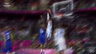

In [120]:
Amu, Alog_var = trained_encoder(train_images[100])
Aresult = trained_decoder(sample(Amu, Alog_var))
display_tensor_image(Aresult[0])

Missing frames 80->89...
Will use GP in latent space to recover these frames

In [121]:
from sklearn.manifold import TSNE

In [148]:
test_features = []
test_labels=[]
for i in range(len(train_images)):
    z, sigma = trained_encoder(train_images[i])
    z = z.detach().numpy()
    z = np.squeeze(z)
    test_features.append(z)
    test_labels.append(i)
    
test_features = np.array(test_features)
test_labels = np.array(test_labels)

#reduce dimensionality to 2D, we consider a subset of data because TSNE
tsne_features = TSNE(n_components=2).fit_transform(test_features)


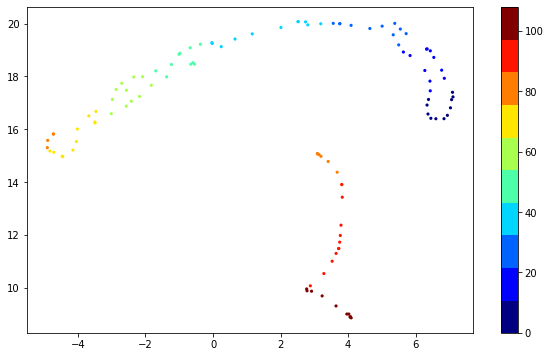

In [142]:
fig = plt.figure(figsize=(10, 6))

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=test_labels[:tsne_features.shape[0]], marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.grid(False)
plt.axis('on')
plt.colorbar()

In [150]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct, WhiteKernel, Sum
from sklearn.gaussian_process import GaussianProcessRegressor

In [183]:
x1 = list(np.linspace(0,79, 80).astype(int))
x2 = list(np.linspace(90,len(images)-1, len(images)-90).astype(int))
X = x1+x2
X = np.array(X).reshape(-1, 1)

In [184]:
len(X)

109

In [185]:
kernel = RBF()*ConstantKernel()+WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=4, random_state=0).fit(X, test_features)
gpr.score(X, test_features)

/Users/joshpapermaster/anaconda3/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9985726736028765

In [186]:
test_x = np.linspace(80,89, 10).astype(int).reshape(-1,1)

In [202]:
predictions, std = gpr.predict(test_x, return_std=True)
predictions = torch.from_numpy(predictions.astype(np.float32))
log_vars =torch.from_numpy(np.log(std**2))

In [203]:
recovered_images=[]
for i in range(len(test_x)):
    recovered_images.append(trained_decoder(sample(predictions[i], log_vars[i])))

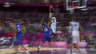

In [220]:
display_tensor_image(recovered_images[8].squeeze())